In [1]:
import fastai
from fastai.vision.all import *
import os
from PIL import Image
import pandas as pd
import shutil
import geopandas as gpd
import xgboost as xgb
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.metrics import mean_absolute_error as mae ,r2_score ,explained_variance_score,max_error,mean_squared_error,mean_absolute_percentage_error,median_absolute_error,mean_gamma_deviance
import matplotlib.pyplot as plt

In [2]:
xgb_model = xgb.XGBRegressor()

#### Dataset

In [3]:
sls = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/3200_sls.csv")

C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (19,20,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
desa = sls.groupby(["iddesa"]).agg({
    'j_kk' : sum,
    'luas' :sum,
     'klas_ur' : max,
    
})

In [5]:
path_pred = Path.cwd() / ("F:/kuliah/Tesis/GGE tesis/images/SPOT DESA EC UNCOVERED")
test_files = [fn for fn in sorted((path_pred).glob('**/*')) if fn.is_file()]
print(len(test_files))
desa_uncovered = []
for i in test_files:
    desa_uncovered.append(str(i)[-14:-4])

5381


In [6]:
sls.shape

(222861, 66)

In [7]:
sls['iddesa'] = sls['iddesa'].apply(str)

In [8]:
sls = sls[sls['iddesa'].isin(desa_uncovered)]

In [9]:
sls = sls.drop_duplicates(subset = ["idsls"])

In [10]:
sls.shape

(200277, 66)

#### Data Exploration

#### Preprocessing

In [11]:
#sls = sls[sls.j_kk >0]

In [12]:
sls.shape

(200277, 66)

In [13]:
xmin = 1
xmax = sls.j_kk.max()

In [14]:
bh = []
bh.append(xmin)
l = 16
for h in range(1,l):
    bh.append(xmin*pow((xmax/xmin),(h/l)))
    
bh.append(xmax)

In [15]:
bh.pop(1)
bh.pop(1)
bh.pop(1)
bh.pop(1)
bh.pop(1)
bh.pop(6)

312.00813319034586

In [16]:
bh = [-1,
 38.654182375330976,
 50,
 65.1536645170477,
 80,
 109.81994027919605,
 145,
 185.1073055111203,
 4245]

In [17]:
bh1 = bh.copy()
bh2 = bh.copy()

In [18]:
bh1.pop(len(bh)-1)
bh2.pop(0)

-1

In [19]:
bins = pd.IntervalIndex.from_arrays(bh1,bh2)
cutter = pd.cut(sls.j_kk, bins)

In [20]:
bins

IntervalIndex([(-1.0, 38.654182375330976], (38.654182375330976, 50.0], (50.0, 65.1536645170477], (65.1536645170477, 80.0], (80.0, 109.81994027919605], (109.81994027919605, 145.0], (145.0, 185.1073055111203], (185.1073055111203, 4245.0]], dtype='interval[float64, right]')

<AxesSubplot:xlabel='j_kk'>

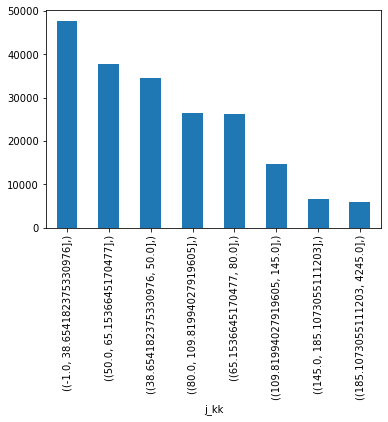

In [21]:
pd.DataFrame(cutter).value_counts().plot(kind='bar')

In [22]:
sls["bin_jk"] = cutter
sls["jk"] = 0

In [23]:
bins

IntervalIndex([(-1.0, 38.654182375330976], (38.654182375330976, 50.0], (50.0, 65.1536645170477], (65.1536645170477, 80.0], (80.0, 109.81994027919605], (109.81994027919605, 145.0], (145.0, 185.1073055111203], (185.1073055111203, 4245.0]], dtype='interval[float64, right]')

In [24]:
j = 1
for i in bins:
    print(j)
    sls.jk[sls.bin_jk == i]= j
    j= j+1

1
2
3
4
5
6
7
8


C:\Users\jwst2\AppData\Local\Temp/ipykernel_45780/3412935534.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sls.jk[sls.bin_jk == i]= j


<AxesSubplot:xlabel='jk'>

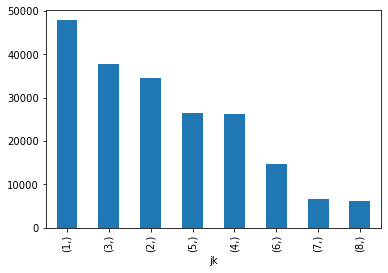

In [25]:
pd.DataFrame(sls.jk).value_counts().plot(kind='bar')

#### Desa Split

In [93]:
desa.shape

(5957, 3)

In [95]:
len(desa_uncovered)

5381

In [96]:
desa['iddesa'] = desa.index
desa['iddesa'] = desa['iddesa'].apply(str)
desa = desa[desa['iddesa'].isin(desa_uncovered)]

In [97]:
desa.shape

(5378, 4)

In [98]:
xmin = desa.j_kk.min()
xmax = desa.j_kk.max()

In [99]:
bh = []
bh.append(xmin)
l = 8
for h in range(1,l):
    bh.append(xmin*pow((xmax/xmin),(h/l)))
    
bh.append(xmax)

In [100]:
bh1 = bh.copy()
bh2 = bh.copy()

bh1.pop(l)
bh2.pop(0)

154

In [101]:
bins = pd.IntervalIndex.from_arrays(bh1,bh2)
cutter = pd.cut(desa.j_kk, bins)

<AxesSubplot:xlabel='j_kk'>

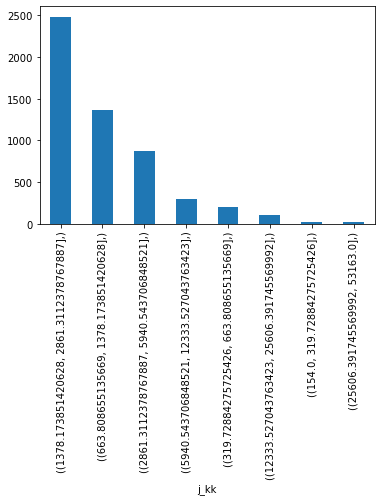

In [102]:
pd.DataFrame(cutter).value_counts().plot(kind='bar')

In [103]:
desa["bin_jk"] = cutter
desa["jk"] = 0

In [104]:
j = 1
for i in bins:
    desa.jk[desa.bin_jk == i]= j
    j= j+1

C:\Users\jwst2\AppData\Local\Temp/ipykernel_17104/1585125175.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  desa.jk[desa.bin_jk == i]= j


In [105]:
X_train, X_test, y_train, y_test = train_test_split(desa.iddesa, desa.jk, test_size=0.10, random_state=42)

In [106]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_train["jk"] = y_train
X_train["status"] = "train"
X_test["jk"] = y_test
X_test["status"] = "test"
split = X_train.append(X_test)

In [110]:
"3202200014" in desa_uncovered

True

In [108]:
split.to_csv("C:/Users/jwst2/Python/tesis/dataset/jkk_test_uncovered.csv")

### other aux

In [25]:
sls = sls.drop_duplicates(subset = ["idsls"])

In [26]:
gdf_01 = gpd.read_file("C:/Users/jwst2/Python/tesis/map/final_sls_3201_2019_1.shp")
gdf_02 = gpd.read_file("C:/Users/jwst2/Python/tesis/map/final_sls_3202_2019_1.shp")
gdf_03 = gpd.read_file("C:/Users/jwst2/Python/tesis/map/final_sls_3203_2019_1.shp")
gdf_04 = gpd.read_file("C:/Users/jwst2/Python/tesis/map/final_sls_3204_2019_1.shp")
gdf_05 = gpd.read_file("C:/Users/jwst2/Python/tesis/map/final_sls_3205_2019_1.shp")
gdf_06 = gpd.read_file("C:/Users/jwst2/Python/tesis/map/final_sls_3206_2019_1.shp")
gdf_07 = gpd.read_file("C:/Users/jwst2/Python/tesis/map/final_sls_3207_2019_1.shp")
gdf_08 = gpd.read_file("C:/Users/jwst2/Python/tesis/map/final_sls_3208_2019_1.shp")
gdf_09 = gpd.read_file("C:/Users/jwst2/Python/tesis/map/final_sls_3209_2019_1.shp")
gdf_10 = gpd.read_file("C:/Users/jwst2/Python/tesis/map/final_sls_3210_2019_1.shp")
gdf_11 = gpd.read_file("C:/Users/jwst2/Python/tesis/map/final_sls_3211_2019_1.shp")
gdf_12 = gpd.read_file("C:/Users/jwst2/Python/tesis/map/final_sls_3212_2019_1.shp")
gdf_13 = gpd.read_file("C:/Users/jwst2/Python/tesis/map/final_sls_3213_2019_1.shp")
gdf_14 = gpd.read_file("C:/Users/jwst2/Python/tesis/map/final_sls_3214_2019_1.shp")
gdf_15 = gpd.read_file("C:/Users/jwst2/Python/tesis/map/final_sls_3215_2019_1.shp")
gdf_16 = gpd.read_file("C:/Users/jwst2/Python/tesis/map/final_sls_3216_2019_1.shp")
gdf_17 = gpd.read_file("C:/Users/jwst2/Python/tesis/map/final_sls_3217_2019_1.shp")
gdf_18 = gpd.read_file("C:/Users/jwst2/Python/tesis/map/final_sls_3218_2019_1.shp")
gdf_71 = gpd.read_file("C:/Users/jwst2/Python/tesis/map/final_sls_3271_2019_1.shp")
gdf_72 = gpd.read_file("C:/Users/jwst2/Python/tesis/map/final_sls_3272_2019_1.shp")
gdf_73 = gpd.read_file("C:/Users/jwst2/Python/tesis/map/final_sls_3273_2019_1.shp")
gdf_74 = gpd.read_file("C:/Users/jwst2/Python/tesis/map/final_sls_3274_2019_1.shp")
gdf_75 = gpd.read_file("C:/Users/jwst2/Python/tesis/map/final_sls_3275_2019_1.shp")
gdf_76 = gpd.read_file("C:/Users/jwst2/Python/tesis/map/final_sls_3276_2019_1.shp")
gdf_77 = gpd.read_file("C:/Users/jwst2/Python/tesis/map/final_sls_3277_2019_1.shp")
gdf_78 = gpd.read_file("C:/Users/jwst2/Python/tesis/map/final_sls_3278_2019_1.shp")
gdf_79 = gpd.read_file("C:/Users/jwst2/Python/tesis/map/final_sls_3279_2019_1.shp")

In [27]:
gdf_01.shape

(17086, 29)

In [28]:
sls["idsls"] = sls["idsls"].apply(int)

In [30]:
sls.shape

(200277, 68)

In [31]:
mypath = 'C:/Users/jwst2/Python/tesis/jpg/JK/04. Spot TC Compare'
os.chdir(mypath)
if os.path.isdir('1') is False:
    for i in range(1,9):
        os.makedirs(str(i))
    

In [32]:
yourpath = "C:/Users/jwst2/Python/tesis/jpg/general sls spot tc/"
z = 0
from tqdm import tqdm
for root, dirs, files in tqdm(os.walk(yourpath, topdown=False)):
    for name in files:
        try :
            if(int(sls.jk[sls.idsls == int(name.replace(".jpg",""))]) == 1):
                shutil.copy(os.path.join(root, name), mypath + "/1/"+name)
            elif(int(sls.jk[sls.idsls == int(name.replace(".jpg",""))] )== 2):
                shutil.copy(os.path.join(root, name), mypath + "/2/"+name)
            elif(int(sls.jk[sls.idsls == int(name.replace(".jpg",""))]) == 3):
                shutil.copy(os.path.join(root, name), mypath + "/3/"+name)
            elif(int(sls.jk[sls.idsls == int(name.replace(".jpg",""))]) == 4):
                shutil.copy(os.path.join(root, name), mypath + "/4/"+name)
            elif(int(sls.jk[sls.idsls == int(name.replace(".jpg",""))]) == 5):
                shutil.copy(os.path.join(root, name), mypath + "/5/"+name)
            elif(int(sls.jk[sls.idsls == int(name.replace(".jpg",""))])== 6):
                shutil.copy(os.path.join(root, name), mypath + "/6/"+name)
            elif(int(sls.jk[sls.idsls == int(name.replace(".jpg",""))]) == 7):
                shutil.copy(os.path.join(root, name), mypath + "/7/"+name)
            elif(int(sls.jk[sls.idsls == int(name.replace(".jpg",""))]) == 8):
                shutil.copy(os.path.join(root, name), mypath + "/8/"+name)
        except Exception:
            z = z+1
            pass 
print(z)

1it [16:41, 1001.96s/it]

19660


In [33]:
split = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/jkk_test_uncovered.csv")

In [34]:
split = split[split.status == "test"]

In [35]:
split.shape

(538, 3)

In [36]:
split_test= split[["iddesa"]]

In [37]:
testpath = 'C:/Users/jwst2/Python/tesis/jpg/JK/test jk spot compare'
os.chdir(testpath)
if os.path.isdir('1') is False:
    for i in range(1,9):
        os.makedirs(str(i))
 

In [38]:
for i in range(1,9):
    print(i)
    yourpath = "C:/Users/jwst2/Python/tesis/jpg/JK/04. Spot TC Compare/" + str(i)
    for root, dirs, files in tqdm(os.walk(yourpath, topdown=False)):
        for name in files:
            try :
                if(split_test.iddesa.astype(str).str.contains(name[:10]).sum() > 0):
                    shutil.move(os.path.join(root, name), "C:/Users/jwst2/Python/tesis/jpg/JK/test jk spot compare/"+str(i)+"/"+name)
            except Exception:
                print(name)
                pass 

1


1it [00:38, 38.32s/it]


2


1it [00:26, 26.34s/it]


3


1it [00:28, 28.60s/it]


4


1it [00:20, 20.58s/it]


5


1it [00:20, 21.00s/it]


6


1it [00:11, 11.30s/it]


7


1it [00:05,  5.01s/it]


8


1it [00:04,  4.52s/it]


### Deeplearnign

In [26]:
mypath = 'C:/Users/jwst2/Python/tesis/jpg/JK/04. Spot TC Compare/'

In [27]:
path = Path.cwd() / (mypath)

In [28]:
Path.BASE_PATH = path
path.ls()

(#8) [Path('1'),Path('2'),Path('3'),Path('4'),Path('5'),Path('6'),Path('7'),Path('8')]

In [29]:
fname = (path/"1").ls()[0]
fname

Path('1/32010100010004.jpg')

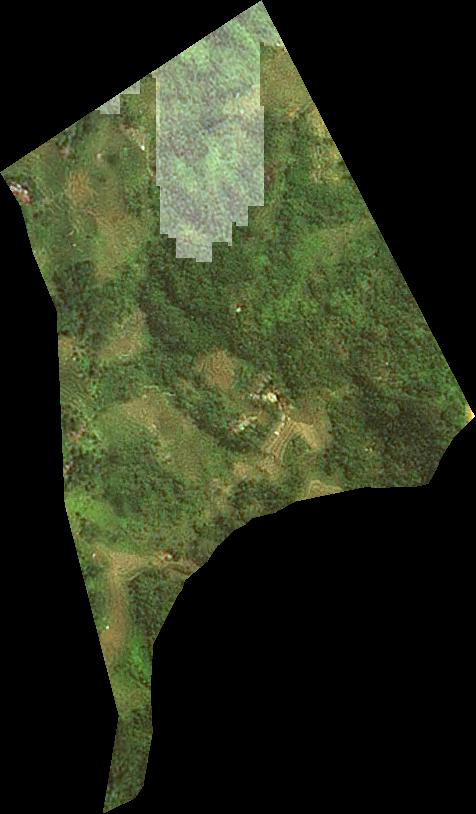

In [30]:
img = Image.open(fname)
img

In [36]:
blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=RandomSplitter(0.1,seed=42),  # default random split 80% training, 20% validation
                 get_y=parent_label,
                 item_tfms = Resize(128)) # data augmentation (mult multiplies the default transformation values)

In [43]:
dls = blocks.dataloaders(path,bs = 6)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


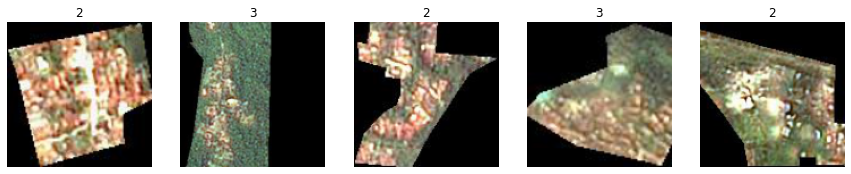

In [44]:
dls.show_batch(nrows=1, ncols=5)

#### Densenet

In [45]:
avg = 'macro'
roca = RocAucBinary(average=avg)
f1s = F1Score(average=avg)
bc = BalancedAccuracy()
metrics=[accuracy,bc, Precision(average=avg), Recall(average=avg), f1s]

In [46]:
learn = cnn_learner(dls, densenet121, metrics=metrics) 

In [47]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,time
0,1.792428,1.642572,0.330697,0.279897,0.282777,0.279897,0.254262,1:26:51
1,1.684592,1.600293,0.341757,0.275024,0.276699,0.275024,0.270300,1:27:02
2,1.693052,1.579113,0.356633,0.300700,0.292187,0.300700,0.261198,1:28:18
3,1.600104,1.557910,0.356467,0.307113,0.256031,0.307113,0.264745,1:28:06
4,1.648978,1.570245,0.356965,0.329205,0.340720,0.329205,0.290026,1:28:37
5,1.678678,1.562065,0.362772,0.321097,0.313031,0.321097,0.295873,1:27:50
6,1.589281,1.532268,0.372117,0.296497,0.309299,0.296497,0.277628,1:26:52
7,1.545374,1.528755,0.375104,0.318646,0.311733,0.318646,0.295391,1:26:06
8,1.573434,1.518299,0.378754,0.321482,0.358723,0.321482,0.291175,1:26:50
9,1.619197,1.523675,0.374717,0.305854,0.313269,0.305854,0.284038,1:31:22


C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\skl

C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


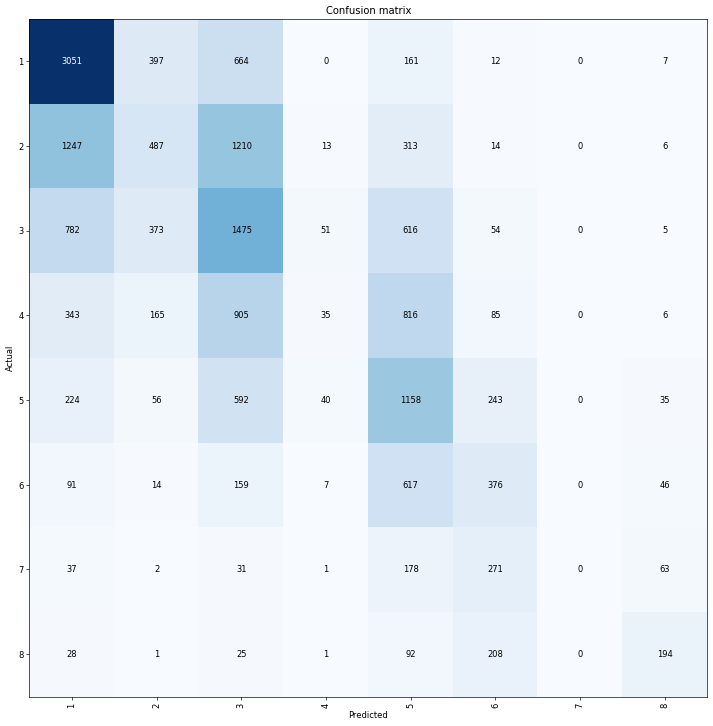

In [48]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

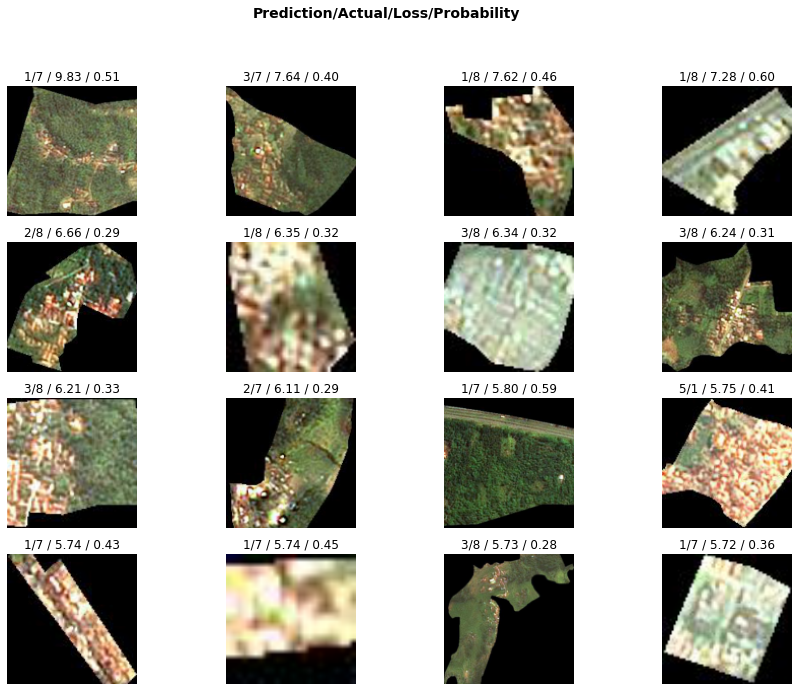

In [51]:
interp.plot_top_losses(16, figsize=(15,11))

In [50]:
learn.export('C:/Users/jwst2/Python/tesis/jumlahkeluarga/models/05. densenet spot sls.pkl')

#### Densenet Xgboost Preprocessing

In [52]:
idx_train = []
for i in dls.train.items:
    idx_train.append(str(i)[-18:-4])
    
idx_valid = []
for i in dls.valid.items:
    idx_valid.append(str(i)[-18:-4])

In [53]:
preds,_ = learn.get_preds(ds_idx  = 0)
result_train = preds.numpy()
new_train = pd.DataFrame(result_train)

preds,_ = learn.get_preds(ds_idx  = 1)
result_test = preds.numpy()
new_test = pd.DataFrame(result_test)


C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
sls = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/3200_sls.csv")
print(sls.shape)
sls = sls.drop_duplicates(subset=['idsls'])
print(sls.shape)
new_test["idsls"] = idx_valid 
new_train["idsls"] = idx_train 
new_dataset = new_train.append(new_test)
new_dataset.idsls = new_dataset.idsls.apply(int)
new_dataset.shape
sls.idsls = sls.idsls.apply(int)
sls.set_index('idsls',inplace = True)
new_dataset.set_index('idsls',inplace=True)
new_dataset.columns = ["prob1","prob2","prob3","prob4","prob5","prob6","prob7","prob8"]
new_dataset = new_dataset.join(sls,how = "left")
new_dataset = new_dataset[ new_dataset["area"].notna()]
new_dataset =  new_dataset[["prob1","prob2","prob3","prob4","prob5","prob6","prob7","prob8","luas","klas_ur","j_kk"]]
new_dataset.columns = ["prob1","prob2","prob3","prob4","prob5","prob6","prob7","prob8","luas","klas_ur","jk"]


C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (19,20,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(222861, 66)
(219919, 66)


In [55]:
path_pred = Path.cwd() / ("C:/Users/jwst2/Python/tesis/jpg/JK/test jk spot compare")
test_files = [fn for fn in sorted((path_pred).glob('**/*')) if fn.is_file()]
print(len(test_files))
test_dl = learn.dls.test_dl(test_files)
preds,_ = learn.get_preds(dl  =test_dl)

19441


In [56]:
idx_test = []
for i in test_files:
    idx_test.append(str(i)[-18:-4])
    
test = pd.DataFrame(preds)
test["idsls"] = idx_test
test.idsls = test.idsls.apply(int)
test.set_index('idsls',inplace=True)
test.columns = ["prob1","prob2","prob3","prob4","prob5","prob6","prob7","prob8"]
test = test.join(sls,how = "left")
df_test =  test[["prob1","prob2","prob3","prob4","prob5","prob6","prob7","prob8","luas","klas_ur","j_kk"]]
df_test.columns = ["prob1","prob2","prob3","prob4","prob5","prob6","prob7","prob8","luas","klas_ur","jk"]

In [57]:
df_test.to_csv("C:/Users/jwst2/Python/tesis/dataset/05. jkk_densenet_sls_spot_test.csv")
new_dataset.to_csv("C:/Users/jwst2/Python/tesis/dataset/05. jkk_densenet_sls_spot_train.csv")

### Densenet XGBoost Basic

In [59]:
df = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/05. jkk_densenet_sls_spot_test.csv")
df_test = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/05. jkk_densenet_sls_spot_train.csv")
X = df.drop(["jk","idsls","klas_ur","luas"],axis = 1)
y = df.jk
X= X*100

In [60]:
xgb_model_basic = xgb.XGBRegressor(colsample_bytree= 0.7,
 learning_rate= 0.01,
 max_depth= 10,
 min_child_weight= 11,
 n_estimators= 500,
 objective= 'reg:squarederror',
 subsample= 0.8,
 use_label_encoder= False)
xgb_model_basic.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=10, min_child_weight=11, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', use_label_encoder=False,
             validate_parameters=1, verbosity=None)

In [61]:
xgb_model_basic.save_model('C:/Users/jwst2/Python/tesis/jumlahkeluarga/models/05. sls spot xgboost.json')

In [62]:
X_test =  df_test.iloc[:,1:9]
X_test = X_test*100
y_test = df_test.jk

In [63]:
print("MAE : ", mae(y_test, xgb_model_basic.predict(X_test)))
print("R2 : ",r2_score(y_test, xgb_model_basic.predict(X_test)))
print("Explained Variance : ",explained_variance_score(y_test,xgb_model_basic.predict(X_test)))
print("Max Error :" ,max_error(y_test, xgb_model_basic.predict(X_test)))
print("MSE : ",mean_squared_error(y_test, xgb_model_basic.predict(X_test)))
#print("MGD : ",mean_gamma_deviance(y_test, xgb_model_basic.predict(X_test)))
print("MedAE : ",median_absolute_error(y_test, xgb_model_basic.predict(X_test)))
print("MAPE : ",mean_absolute_percentage_error(y_test, xgb_model_basic.predict(X_test)))

MAE :  23.092822909260153
R2 :  0.40007236455907835
Explained Variance :  0.4009711526235106
Max Error : 4108.017501831055
MSE :  2029.6321441340451
MedAE :  15.04721450805664
MAPE :  7568852101375971.0


###### Estimasi desa

In [64]:
df_test["jk_pred"] = xgb_model_basic.predict(X_test)
df_test["iddesa"] = df_test["idsls"].apply(str).str[0:10]
df_test_desa = df_test.groupby(["iddesa"]).agg({
    'jk' : sum,
    'jk_pred' :sum
    
})

In [65]:
print("MAE : ", mae(df_test_desa.jk, df_test_desa.jk_pred))
print("R2 : ",r2_score(df_test_desa.jk, df_test_desa.jk_pred))
print("Explained Variance : ",explained_variance_score(df_test_desa.jk, df_test_desa.jk_pred))
print("Max Error :" ,max_error(df_test_desa.jk, df_test_desa.jk_pred))
print("MSE : ",mean_squared_error(df_test_desa.jk, df_test_desa.jk_pred))
print("MGD : ",mean_gamma_deviance(df_test_desa.jk, df_test_desa.jk_pred))
print("MedAE : ",median_absolute_error(df_test_desa.jk, df_test_desa.jk_pred))
print("MAPE : ",mean_absolute_percentage_error(df_test_desa.jk, df_test_desa.jk_pred))


MAE :  393.11737998457977
R2 :  0.91696701439844
Explained Variance :  0.9176437850472954
Max Error : 10201.9033203125
MSE :  520791.5809058615
MGD :  0.04904852879756087
MedAE :  234.54931640625
MAPE :  0.1636874559581536
